# Logistic Regression

In [68]:
# Data Manipulation
import numpy as np
import pandas as pd

# Technical Indicators
import talib as ta

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [69]:
df = pd.read_csv('data/AAPL_data.csv')

In [70]:
df.dropna()
df = df[df['Date'] >= '2022-01-01']
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
1179,2022-01-03,182.880005,177.710007,177.830002,182.009995,104487900.0,181.778397
1180,2022-01-04,182.940002,179.119995,182.630005,179.699997,99310400.0,179.471344
1181,2022-01-05,180.169998,174.639999,179.610001,174.919998,94537600.0,174.697418
1182,2022-01-06,175.300003,171.639999,172.699997,172.000000,96904000.0,171.781143
1183,2022-01-07,174.139999,171.029999,172.889999,172.169998,86709100.0,171.950928


**Feature definition**  
- 10-days moving average, correlation, relative strength index (to measure speed and change of price movement)  
- difference between open price for today and close price for ytd  
- difference between open price for today and open price for ytd  
- open, high, low, close price of today 

In [71]:
df['S_10'] = df['Close'].rolling(window=10).mean() #Li and Pan (2022) also used 10 day training window
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod=10)
df['Open - Close'] = df['Open'] - df['Close'].shift(1)
df['Open - Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
X = df[['High', 'Low', 'Open', 'Close', 'S_10', 'Corr', 'RSI', 'Open - Close', 'Open - Open']]

**Add classification variable**  
- y = 1 if the next day's closing price is higher than today's closing price  
- y = -1 if the next day's closing price is lower than today's closing price

In [72]:
y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)

In [73]:
split = int(0.8 * len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [74]:
len(X_train)

50

In [75]:
len(X_test)

13

**Logistic Regression**  
- train the model with X_train and y_train

In [76]:
model = LogisticRegression(max_iter=float('inf'))
model = model.fit(X_train, y_train)

In [77]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,High,[0.4131942594470997]
1,Low,[-0.4299313163366996]
2,Open,[-0.18958757926069303]
3,Close,[0.0507655659096827]
4,S_10,[-0.024166319597173486]
5,Corr,[-0.2421294930552509]
6,RSI,[0.07924664275347396]
7,Open - Close,[-0.10752601431594652]
8,Open - Open,[-0.007559571472130151]


In [78]:
y_predict = model.predict(X_test)

**Evaluate the model**

In [79]:
metrics.confusion_matrix(y_test, y_predict)

array([[5, 3],
       [4, 1]], dtype=int64)

In [80]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

          -1       0.56      0.62      0.59         8
           1       0.25      0.20      0.22         5

    accuracy                           0.46        13
   macro avg       0.40      0.41      0.41        13
weighted avg       0.44      0.46      0.45        13



**Conclusion**  
The accuracy of the model is around 0.56. The precision of predicting -1 (price fall) is 0.57, and that of predicting 1 (price rise) is 0.53.  
It is noticeable that the above accuracy is not very high, meaning the logistic regression model is not predicting many True Positives or True Negatives correctly. And to increase the accuracy, we may need more sophisticated ML models than Logistic Regression.

followed the tutorial and changed based on dataset:  
https://blog.quantinsti.com/machine-learning-logistic-regression-python/#:~:text=Logistic%20Regression%20and%20Linear%20regression&text=It%20is%20a%20classification%20problem,as%20a%20generalized%20linear%20model.

# Random Forest

In [81]:
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from pprint import pprint

In [82]:
df = pd.read_csv('data/AAPL_data.csv')
df.dropna()
df = df[df['Date'] >= '2021-01-01']
df.set_index('Date', inplace=True)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,128.453461
2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,130.041626
2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.664207
2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.952271
2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,131.073929


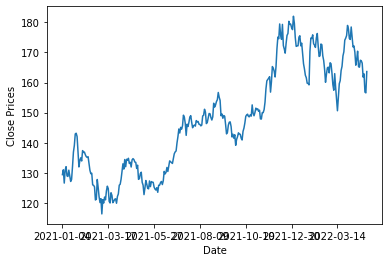

In [83]:
df['Close'].plot()
plt.ylabel('Close Prices')
plt.show()

**Feature Selection**  
- sklearn seems to have feature importance module with a forest of trees, could refer to in future: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [84]:
df['S_10'] = df['Close'].rolling(window=10).mean() #Li and Pan (2022) also used 10 day training window
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod=10)
df['Open - Close'] = df['Open'] - df['Close'].shift(1)
df['Open - Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
X = df[['High', 'Low', 'Open', 'Close', 'S_10', 'Corr', 'RSI', 'Open - Close', 'Open - Open']].values
y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)

In [85]:
X.shape

(315, 9)

In [86]:
y.shape

(315,)

In [87]:
split = int(0.8 * len(df))
x_train, x_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

**RF Model**

In [88]:
rf = RandomForestRegressor(random_state = 42)
# Look at parameters used by current forest, and the param need to be tuned to find the best 
# for our current dataset
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [89]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [90]:
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [91]:
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [92]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [93]:
model = RandomForestRegressor(n_estimators=600, min_samples_split=10, \
        min_samples_leaf=1, max_features='sqrt', max_depth=110, bootstrap=True,)

In [94]:
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=110, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [95]:
predict = model.predict(x_test)
predict

array([ 0.294663  ,  0.33998307,  0.45642201,  0.37010712,  0.34062892,
        0.13163953,  0.20576155,  0.184563  , -0.14254245,  0.1972733 ,
        0.03779304, -0.02817807,  0.27776555,  0.09413803, -0.05480858,
        0.06541988, -0.27371779, -0.03655011, -0.40255471, -0.18655714,
       -0.22369007, -0.15985004,  0.21684716,  0.02504279, -0.13142529,
       -0.02215386, -0.25401456,  0.15649597,  0.00969067, -0.21847049,
       -0.27171748, -0.13271971, -0.01880035,  0.10387463,  0.4294296 ,
        0.49509449,  0.4359704 ,  0.37076122,  0.14598782,  0.28713482,
       -0.14476338, -0.4870046 , -0.4535366 , -0.06825011, -0.0089514 ,
       -0.13012541,  0.00116639,  0.26931963,  0.2307187 ,  0.21462019,
       -0.123513  ,  0.17087019,  0.06744117, -0.03299199, -0.3325364 ,
       -0.17670424, -0.08781806,  0.07490332, -0.4954432 , -0.35745798,
       -0.19395078, -0.24850431,  0.11781866])

In [96]:
y_predict = np.where(predict > 0, 1, -1)

In [97]:
metrics.confusion_matrix(y_test, y_predict)

array([[16, 18],
       [15, 14]], dtype=int64)

In [98]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

          -1       0.52      0.47      0.49        34
           1       0.44      0.48      0.46        29

    accuracy                           0.48        63
   macro avg       0.48      0.48      0.48        63
weighted avg       0.48      0.48      0.48        63

